## Scenario6 - Study Drone count vs Uncertainty

In [2]:
from scipy.optimize import least_squares
import numpy as np
import time
from pandas import DataFrame
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import sem

### Method to generate drone position required for simulation

In [3]:
def fun_generate_drone_pos(drone_count):
    lpos = []
    for i in range(drone_count):
        xy=np.random.uniform(-10,10,2)
        x=xy[0]
        y=xy[1]
        z=np.random.uniform(2,7,1)[0]
        lpos.append(x)
        lpos.append(y)
        lpos.append(z)
    #print(lpos)
    return (np.asarray(lpos).reshape(1,drone_count, 3))
#fun_generate_drone_pos()

### Calculate the time-of-flight data with the actual drone position and ground object location

In [26]:
#not used
def calc_timelags_realdp(n, d_pos_orig):
    json_loc = {}
    list_orig_y = []
    json1 = {}
    for i in range(n):
        for k in range(i, n):
            outer = i + 1
            inner = k + 1
            key = "" + str(outer) +"_"+ str(inner)

            if(i==k):
                val=  math.sqrt(sum((x_original-d_pos_orig[0][i])**2)) * 2 
                pos1 = d_pos_orig[0][i]
                pos2 = ""
                #print(key, " ", val)
            else: 
                #print(key , ",", "i = ", i, "k=", k)
                val = math.sqrt(sum((x_original-d_pos_orig[0][outer-1])**2)) + math.sqrt(sum((x_original-d_pos_orig[0][inner-1])**2))
                pos1 = d_pos_orig[0][outer-1]
                pos2 = d_pos_orig[0][inner-1]
                #print(key, " ", val)
            
            json11 = {key: val, "pos1":pos1, "pos2":pos2 }
            json1.update(json11)
            list_orig_y.append(json11)
            #json.append(json1)

    #print(json1)
    return list_orig_y
    
#y = [9.095598162479572,9.282884570730419,12.974780298767472,5.403702434442518,12.787493890516625,13.162066707018319]

### Calculate the time-of-flight data with the noisy drone position and ground object location

In [4]:
def calc_timelags_noisedp(n, dp_orig, dp_noise):
    json_loc = {}
    list_orig_y = []
    json1 = {}
    for i in range(n):
        for k in range(i, n):
            outer = i + 1
            inner = k + 1
            key = "" + str(outer) +"_"+ str(inner)

            if(i==k):
                val=  math.sqrt(sum((x_original-dp_orig[0][i])**2)) * 2 
                pos1 = dp_noise[0][i]
                pos2 = ""
                #print(key, " ", val)
            else: 
                #print(key , ",", "i = ", i, "k=", k)
                val = math.sqrt(sum((x_original-dp_orig[0][outer-1])**2)) + math.sqrt(sum((x_original-dp_orig[0][inner-1])**2))
                pos1 = dp_noise[0][outer-1]
                pos2 = dp_noise[0][inner-1]
                #print(key, " ", val)
            
            json11 = {key: val, "pos1":pos1, "pos2":pos2 }
            json1.update(json11)
            list_orig_y.append(json11)
            #json.append(json1)

    #print(json1)
    return list_orig_y
    
#y = [9.095598162479572,9.282884570730419,12.974780298767472,5.403702434442518,12.787493890516625,13.162066707018319]

### Calculate the difference bw actual and recovered object location

In [5]:
def calc_recored_go_pos_err(actual_go,recovered_go):
#     print(actual_go)
#     print("-----",recovered_go)

    #print("-----")
    sq_diff=((actual_go-recovered_go)**2)
    #print(type(sq_diff))
    #print(sq_diff)
    total_sum_go_err = np.sqrt(  sq_diff[0]) + np.sqrt( sq_diff[1]) + np.sqrt( sq_diff[2])
    #print(recovered_go,actual_go,sq_diff,total_sum_go_err)
    #print(total_sum_3drone_err)
    return total_sum_go_err

### Objective function to recover the object location - the function takes input as initial guess of object location, drone coordinates, time-of-flight and LS method iteratively calls this function to minimize

In [6]:

def recover_GO_pos(x ):

    x[2]=0
    #print("hi--")
    list_orig_y = list_temp_json[0]
    #print((list_orig_y))
    listval =[]

    for json_y in list_orig_y:
        c = 0
        for key in json_y:
            # execute the logic only once per json obj(there are 3 keys), c=0 controls this logic
            if(c==0):
                #print("json--", json_y)
                #print("key--",key)
                v = json_y[key]
                #print("v===",v)
                k = key.split("_")
                k1 = k[0]
                k2 = k[1]
                
                k1=k1.strip()
                k1=int(k1)
                
                k2=k2.strip()
                k2=int(k2)

                if(k1==k2):
                    val=  v - math.sqrt(sum((x-json_y["pos1"])**2))* 2
                    listval.append(val)
                else:
                    val = v - (math.sqrt(sum((x-json_y["pos1"])**2)) + math.sqrt(sum((x-json_y["pos2"])**2)))
                    listval.append(val)
                    
            c = 1
    #print("listval---",listval)
    an_array = np.array(listval)
    an_array1 = an_array**2
    loss = sum(an_array1)
    #print(loss)
    #print("loss---",loss)
    return np.array(loss)


### Function to add noise to drone position

In [7]:
def addnoise_to_drone_pos(dp_orig, sd):
    #d_pos=np.array([[[4.3,4.3,0.8],[2.4,-1.2,5.4],[6.9,0.1,4.7]]])
    noise = np.random.normal(0, sd, dp_orig.shape)
    #print(noise)
    dp_noise = dp_orig + noise
    #d_pos=np.array([[[4.4,4.4,0.9],[2.4,-1.2,5.4],[6.9,0.1,4.7]]])
    return dp_noise
    #print(d_pos)  

### Generate a list containing noise levels - standard deviation in drone position

In [25]:
# np.linspace(0,1,11)
# arr_noise_sd = np.arange(0.1,3.1, 0.1) # drones r 3m/9ft apart
# arr_noise_sd.shape,type(arr_noise_sd)
# arr_noise_sd

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. ])

In [26]:
np.linspace(0,1,11)
arr_noise_sd = np.arange(0.0,1, 0.01) # drones r 3m/9ft apart
arr_noise_sd.shape,type(arr_noise_sd)
arr_noise_sd

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

### Variable initilization

In [9]:
x_original=np.array([2.8,2.2,0])
xy_initial = np.array([0,0,0]) 

# Invoke LS with different drone count for various noise levels

# Drone Count = 3

In [29]:
drone_count=3
start_time = time.time()

list_temp_json = []

df_results3 = DataFrame(columns=['uncer_dp', 'uncer_rec_go', 'sd_rec_go_pos', 'std_err_rec_go_pos'])
ite = 0
for noise_sd in arr_noise_sd:
    list_goerror = []
    ite +=1
    for iterations in range(300):
        list_temp_json.clear()
        dp_real = fun_generate_drone_pos(drone_count)
        dp_noise = addnoise_to_drone_pos(dp_real,sd=noise_sd)
        list_orig_y = calc_timelags_noisedp(drone_count,dp_real, dp_noise)
        list_temp_json.insert(0, list_orig_y)

        result = least_squares(recover_GO_pos, xy_initial)
        err_go = calc_recored_go_pos_err(x_original,result.x)

        list_goerror.append(err_go)
        
    avg_err_go = np.mean(list_goerror)
    sd_rec_calc_gopos = np.std(list_goerror) # sd of rec go obj pos
    std_err_calc_gopos = sem(list_goerror)   # std dev of rec go obj pos = sd/sqrt(n-1)
    df_results3.loc[ite-1] = [noise_sd, avg_err_go, sd_rec_calc_gopos,std_err_calc_gopos]

print("--- %s seconds ---" % (time.time() - start_time))      


--- 713.691999912262 seconds ---


In [21]:
len(list_temp_json)

1

# Drone Count = 6

In [30]:
drone_count=6
start_time = time.time()

list_temp_json = []

df_results6 = DataFrame(columns=['uncer_dp', 'uncer_rec_go', 'sd_rec_go_pos', 'std_err_rec_go_pos'])
ite = 0
for noise_sd in arr_noise_sd:
    list_goerror = []
    ite +=1
    for iterations in range(300):
        list_temp_json.clear()
        dp_real = fun_generate_drone_pos(drone_count)
        dp_noise = addnoise_to_drone_pos(dp_real,sd=noise_sd)
        list_orig_y = calc_timelags_noisedp(drone_count,dp_real, dp_noise)
        list_temp_json.insert(0, list_orig_y)

        result = least_squares(recover_GO_pos, xy_initial)
        err_go = calc_recored_go_pos_err(x_original,result.x)

        list_goerror.append(err_go)
        
    avg_err_go = np.mean(list_goerror)
    sd_rec_calc_gopos = np.std(list_goerror) # sd of rec go obj pos
    std_err_calc_gopos = sem(list_goerror)   # std dev of rec go obj pos = sd/sqrt(n-1)
    df_results6.loc[ite-1] = [noise_sd, avg_err_go, sd_rec_calc_gopos,std_err_calc_gopos]

print("--- %s seconds ---" % (time.time() - start_time))      


--- 694.4322853088379 seconds ---


# Drone Count = 9

In [31]:
drone_count=9
start_time = time.time()

list_temp_json = []

df_results9 = DataFrame(columns=['uncer_dp', 'uncer_rec_go', 'sd_rec_go_pos', 'std_err_rec_go_pos'])
ite = 0
for noise_sd in arr_noise_sd:
    list_goerror = []
    ite +=1
    for iterations in range(300):
        list_temp_json.clear()
        dp_real = fun_generate_drone_pos(drone_count)
        dp_noise = addnoise_to_drone_pos(dp_real,sd=noise_sd)
        list_orig_y = calc_timelags_noisedp(drone_count,dp_real, dp_noise)
        list_temp_json.insert(0, list_orig_y)

        result = least_squares(recover_GO_pos, xy_initial)
        err_go = calc_recored_go_pos_err(x_original,result.x)

        list_goerror.append(err_go)
        
    avg_err_go = np.mean(list_goerror)
    sd_rec_calc_gopos = np.std(list_goerror) # sd of rec go obj pos
    std_err_calc_gopos = sem(list_goerror)   # std dev of rec go obj pos = sd/sqrt(n-1)
    df_results9.loc[ite-1] = [noise_sd, avg_err_go, sd_rec_calc_gopos,std_err_calc_gopos]

print("--- %s seconds ---" % (time.time() - start_time))      


--- 927.6558384895325 seconds ---


# Drone Count = 12

In [32]:
drone_count=12
start_time = time.time()

list_temp_json = []

df_results12 = DataFrame(columns=['uncer_dp', 'uncer_rec_go', 'sd_rec_go_pos', 'std_err_rec_go_pos'])
ite = 0
for noise_sd in arr_noise_sd:
    list_goerror = []
    ite +=1
    for iterations in range(300):
        list_temp_json.clear()
        dp_real = fun_generate_drone_pos(drone_count)
        dp_noise = addnoise_to_drone_pos(dp_real,sd=noise_sd)
        list_orig_y = calc_timelags_noisedp(drone_count,dp_real, dp_noise)
        list_temp_json.insert(0, list_orig_y)

        result = least_squares(recover_GO_pos, xy_initial)
        err_go = calc_recored_go_pos_err(x_original,result.x)

        list_goerror.append(err_go)
        
    avg_err_go = np.mean(list_goerror)
    sd_rec_calc_gopos = np.std(list_goerror) # sd of rec go obj pos
    std_err_calc_gopos = sem(list_goerror)   # std dev of rec go obj pos = sd/sqrt(n-1)
    df_results12.loc[ite-1] = [noise_sd, avg_err_go, sd_rec_calc_gopos,std_err_calc_gopos]

print("--- %s seconds ---" % (time.time() - start_time))      


--- 1536.3121552467346 seconds ---


# Drone Count = 30

In [39]:
drone_count=30
start_time = time.time()

list_temp_json = []

df_results30 = DataFrame(columns=['uncer_dp', 'uncer_rec_go', 'sd_rec_go_pos', 'std_err_rec_go_pos'])
ite = 0
for noise_sd in arr_noise_sd:
    list_goerror = []
    ite +=1
    for iterations in range(300):
        list_temp_json.clear()
        dp_real = fun_generate_drone_pos(drone_count)
        dp_noise = addnoise_to_drone_pos(dp_real,sd=noise_sd)
        list_orig_y = calc_timelags_noisedp(drone_count,dp_real, dp_noise)
        list_temp_json.insert(0, list_orig_y)

        result = least_squares(recover_GO_pos, xy_initial)
        err_go = calc_recored_go_pos_err(x_original,result.x)

        list_goerror.append(err_go)
        
    avg_err_go = np.mean(list_goerror)
    sd_rec_calc_gopos = np.std(list_goerror) # sd of rec go obj pos
    std_err_calc_gopos = sem(list_goerror)   # std dev of rec go obj pos = sd/sqrt(n-1)
    df_results30.loc[ite-1] = [noise_sd, avg_err_go, sd_rec_calc_gopos,std_err_calc_gopos]

print("--- %s seconds ---" % (time.time() - start_time))      


--- 7283.165296554565 seconds ---


### Plot scatter plot of uncertainty in drone pos vs uncertainty in object location for various drone count

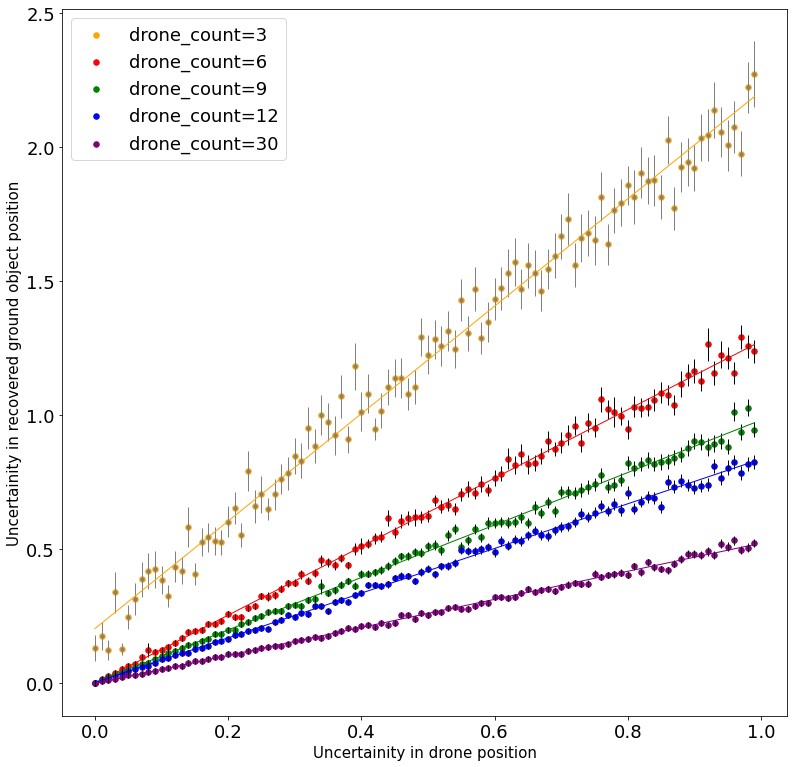

In [54]:
plt.rcParams.update({'font.size': 13})

regr = linear_model.LinearRegression()    
regr.fit(df_results3[['uncer_dp'] ],df_results3[['uncer_rec_go']])  
plt.rcParams.update({'font.size': 18})
ax = df_results3.plot(kind="scatter", x="uncer_dp",y="uncer_rec_go", color="orange", label="drone_count=3",figsize=(13, 13),s=30)
ax.errorbar(df_results3['uncer_dp'] ,df_results3['uncer_rec_go'], yerr=df_results3['std_err_rec_go_pos'], fmt='.', color="grey",elinewidth=1)
plt.plot   (df_results3[['uncer_dp'] ], regr.predict(df_results3[['uncer_dp'] ]), color='orange', linewidth=1)

regr = linear_model.LinearRegression()    
regr.fit(df_results6[['uncer_dp'] ],df_results6[['uncer_rec_go']])  
ax=df_results6.plot(kind="scatter", x="uncer_dp",y="uncer_rec_go", color="red", label="drone_count=6", ax=ax,s=30)
ax.errorbar(df_results6['uncer_dp'] ,df_results6['uncer_rec_go'], yerr=df_results6['std_err_rec_go_pos'], fmt='|', color="black",elinewidth=1)
plt.plot   (df_results6[['uncer_dp'] ], regr.predict(df_results6[['uncer_dp'] ]), color='red', linewidth=1)

regr = linear_model.LinearRegression()    
regr.fit(df_results9[['uncer_dp'] ],df_results9[['uncer_rec_go']])  
ax=df_results9.plot(kind="scatter", x="uncer_dp",y="uncer_rec_go", color="green", label="drone_count=9", ax=ax,s=30)
ax.errorbar(df_results9['uncer_dp'] ,df_results9['uncer_rec_go'], yerr=df_results9['std_err_rec_go_pos'], fmt='|', color="black",elinewidth=1)
plt.plot   (df_results9[['uncer_dp'] ], regr.predict(df_results9[['uncer_dp'] ]), color='green', linewidth=1)

regr = linear_model.LinearRegression()    
regr.fit(df_results12[['uncer_dp'] ],df_results12[['uncer_rec_go']]) 
df_results12.plot(kind="scatter", x="uncer_dp",y="uncer_rec_go", color="blue", label="drone_count=12", ax=ax,s=30)
ax.errorbar(df_results12['uncer_dp'] ,df_results12['uncer_rec_go'], yerr=df_results12['std_err_rec_go_pos'], fmt='|', color="black",elinewidth=1)
plt.plot   (df_results12[['uncer_dp'] ], regr.predict(df_results12[['uncer_dp'] ]), color='blue', linewidth=1)

regr = linear_model.LinearRegression()    
regr.fit(df_results30[['uncer_dp'] ],df_results30[['uncer_rec_go']]) 
df_results30.plot(kind="scatter", x="uncer_dp",y="uncer_rec_go", color="purple", label="drone_count=30", ax=ax,s=30)
ax.errorbar(df_results30['uncer_dp'] ,df_results30['uncer_rec_go'], yerr=df_results30['std_err_rec_go_pos'], fmt='|', color="black",elinewidth=1)
plt.plot   (df_results30[['uncer_dp'] ], regr.predict(df_results30[['uncer_dp'] ]), color='purple', linewidth=1)

#ax.set_xlabel("delta (Standard Deviation of noise)")
ax.set_xlabel("Uncertainity in drone position",fontdict={'fontsize':15})
ax.set_ylabel("Uncertainity in recovered ground object position",fontdict={'fontsize':15})
plt.show()